In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 250)

import rpy2
print(rpy2.__version__)

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')
mn = importr('metansue')


from rpy2.robjects import numpy2ri
numpy2ri.activate()

grdevices = importr('grDevices')
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri


3.1.0


/Users/nielsond/miniconda3/envs/ge2/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
data_path = Path('../great_expectations_data/data')
output_path = Path('../great_expectations_data/cleaned_data')
output_path.mkdir(exist_ok=True)
figure_path = Path('../great_expectations_figures/')
figure_path.mkdir(exist_ok=True)

In [4]:
excel_path = data_path/'./quality_and_data_extraction-nielsond.xlsx'
ml = pd.read_excel(excel_path, sheet_name="master list")
groups = pd.read_excel(excel_path, sheet_name="group_info")
qual = pd.read_excel(excel_path, sheet_name="pred_qual_da")
pi_eeg = pd.read_excel(excel_path, sheet_name="pred_info_eeg")
pi_fmri = pd.read_excel(excel_path, sheet_name="pred_info_fmri")
effects = pd.read_excel(excel_path, sheet_name="effects")

# Run random effects meta-analysis
## Rearrange data

In [5]:
def F_to_r(F, dfn, dfd):
    return np.sqrt((np.abs(F) * dfn) / ((np.abs(F) * dfn) + dfd)) * np.sign(F)

def t_to_r(t, df):
    return np.sqrt((t**2)/(t**2 + df)) * np.sign(t)

def B_to_r(B, se, df):
    t = B / se
    return t_to_r(t,df)

def F_to_d(F, dfn, dfd):
    return 2 * np.sqrt((dfn * np.abs(F))/dfd) * np.sign(F)

def t_to_d(t, df):
    return ((2 * t) / np.sqrt(df))

def B_to_d(B, se, df):
    t = B / se
    return t_to_d(t,df)

def r_to_d(r):
    return np.sqrt((4 * (r**2)) / (1 - (r**2))) * np.sign(r)

def z_var(n):
    return (1/(n-3))

def z_se(n):
    return (np.sqrt(z_var(n)))

assert z_var(100) == 0.010309278350515464
assert z_se(100) == 0.1015346165133619

In [6]:
big_sheet = pd.concat([pi_eeg, pi_fmri], sort=False)
big_sheet = groups.merge(big_sheet, left_on = ['paper_id', 'group_id'], right_on=['paper_id','group1_id'])
big_sheet = big_sheet.merge(effects, on=['paper_id', 'pred_id'])
big_sheet = ml.merge(big_sheet, on='paper_id')
big_sheet['r'] = np.nan
big_sheet['d'] = np.nan


# fill in df where it's missing
missing_df_ind = ((big_sheet.statistic == "t") 
                  | (big_sheet.statistic.str.lower() == "b") 
                  | (big_sheet.statistic.str.lower() == "r")
                  | (big_sheet.statistic == "NSUE")) & big_sheet.df_1.isnull()
big_sheet.loc[ missing_df_ind , 'df_1'] = big_sheet.loc[missing_df_ind, 'n'] - 1

# Flip signs as indicated
big_sheet.loc[big_sheet.flip_for_analysis == 1, 'value'] = big_sheet.loc[big_sheet.flip_for_analysis == 1, 'value']  * -1

# convert Fs, bs and ts to rs
big_sheet.loc[big_sheet.statistic == "F", 'r'] = big_sheet.loc[big_sheet.statistic == "F", ['value', 'df_1', 'df_2']].apply(lambda row:F_to_r(row.value, row.df_1, row.df_2), axis=1)
big_sheet.loc[big_sheet.statistic == "t", 'r'] = big_sheet.loc[big_sheet.statistic == "t", ['value', 'df_1']].apply(lambda row:t_to_r(row.value, row.df_1), axis=1)
big_sheet.loc[big_sheet.statistic == "B", 'r'] = big_sheet.loc[big_sheet.statistic == "B", ['value', 'std_error', 'df_1']].apply(lambda row:B_to_r(row.value, row.std_error, row.df_1), axis=1)
big_sheet.loc[big_sheet.statistic == "b", 'r'] = big_sheet.loc[big_sheet.statistic == "b", ['value', 'std_error', 'df_1']].apply(lambda row:B_to_r(row.value, row.std_error, row.df_1), axis=1)
big_sheet.loc[big_sheet.statistic == "r", 'r'] = big_sheet.loc[big_sheet.statistic == "r", 'value']

# convert Fs, bs and ts to ds
big_sheet.loc[big_sheet.statistic == "F", 'd'] = big_sheet.loc[big_sheet.statistic == "F", ['value', 'df_1', 'df_2']].apply(lambda row:F_to_d(row.value, row.df_1, row.df_2), axis=1)
big_sheet.loc[big_sheet.statistic == "t", 'd'] = big_sheet.loc[big_sheet.statistic == "t", ['value', 'df_1']].apply(lambda row:t_to_d(row.value, row.df_1), axis=1)
big_sheet.loc[big_sheet.statistic == "B", 'd'] = big_sheet.loc[big_sheet.statistic == "B", ['value', 'std_error', 'df_1']].apply(lambda row:B_to_d(row.value, row.std_error, row.df_1), axis=1)
big_sheet.loc[big_sheet.statistic == "b", 'd'] = big_sheet.loc[big_sheet.statistic == "b", ['value', 'std_error', 'df_1']].apply(lambda row:B_to_d(row.value, row.std_error, row.df_1), axis=1)
big_sheet.loc[big_sheet.statistic == "r", 'd'] = big_sheet.loc[big_sheet.statistic == "r", ['value']].apply(lambda row:r_to_d(row.value), axis=1)

# Get n for meta analysis
big_sheet.loc[big_sheet.statistic == "F", 'meta_n'] =  big_sheet.loc[big_sheet.statistic == "F", 'df_2'] + 1
big_sheet.loc[big_sheet.statistic != "F", 'meta_n'] =  big_sheet.loc[big_sheet.statistic != "F", 'df_1'] + 1

# Set age string for table
big_sheet['Age'] = [f"{rr.age__mean:0.1f} ({rr.age__std:0.1f})" if pd.notnull(rr.age__std) else f"{rr.age__mean:0.1f}" for ix,rr in big_sheet.iterrows()]
big_sheet.loc[big_sheet.age__mean.isnull() & big_sheet.age__range.notnull(), 'Age'] = big_sheet.loc[big_sheet.age__mean.isnull() & big_sheet.age__range.notnull(), 'age__range']
big_sheet.loc[big_sheet.Age.isnull(), 'Age'] = ""
big_sheet['Female'] = [f"{rr.pct_female:0.2f}%" if pd.notnull(rr.pct_female) else "" for ix,rr in big_sheet.iterrows()]
big_sheet.loc[(big_sheet.Female == "") & big_sheet.pct_female_string.notnull(), 'Female'] = big_sheet.loc[(big_sheet.Female == "") & big_sheet.pct_female_string.notnull(), 'pct_female_string']
big_sheet['BSL Meds'] = [f"{rr.pct_meds:0.2f}%" if pd.notnull(rr.pct_meds) else "" for ix,rr in big_sheet.iterrows()]
big_sheet['Population'] = [f"{rr.group_type}" if not rr.group_type == "other" else f"{rr.diag_if_other}" for ix,rr in big_sheet.iterrows()]
big_sheet['Treatment'] = [f"{rr.treatment__name}" if pd.notnull(rr.treatment__name) else "" for ix,rr in big_sheet.iterrows()]


In [7]:
big_sheet['include_any'] =  big_sheet.loc[:, ['treat_include_str', 'obs_include_str', 'treat_include_wb', 'obs_include_wb']].sum(1).astype(bool).astype(int)

In [8]:
# Thre are 8 tests
# specific and global for obs and treat for fmri and eeg
fmri_ind = (big_sheet['fmri'] == 'yes').astype(bool)
eeg_ind = (big_sheet['fmri'] == 'no').astype(bool)

big_sheet['fmri_spc_trt'] = 0
big_sheet.loc[fmri_ind & big_sheet.treat_include_str == 1, 'fmri_spc_trt'] = 1
big_sheet['fmri_spc_obs'] = 0
big_sheet.loc[fmri_ind & big_sheet.obs_include_str == 1, 'fmri_spc_obs'] = 1

big_sheet['fmri_glb_trt'] = 0
big_sheet.loc[fmri_ind & big_sheet.treat_include_wb == 1, 'fmri_glb_trt'] = 1
big_sheet['fmri_glb_obs'] = 0
big_sheet.loc[fmri_ind & big_sheet.obs_include_wb == 1, 'fmri_glb_obs'] = 1

big_sheet['eeg_spc_trt'] = 0
big_sheet.loc[eeg_ind & big_sheet.treat_include_str == 1, 'eeg_spc_trt'] = 1
big_sheet['eeg_spc_obs'] = 0
big_sheet.loc[eeg_ind & big_sheet.obs_include_str == 1, 'eeg_spc_obs'] = 1

big_sheet['eeg_glb_trt'] = 0
big_sheet.loc[eeg_ind & big_sheet.treat_include_wb == 1, 'eeg_glb_trt'] = 1
big_sheet['eeg_glb_obs'] = 0
big_sheet.loc[eeg_ind & big_sheet.obs_include_wb == 1, 'eeg_glb_obs'] = 1

hyp_cols = ['fmri_spc_trt', 'fmri_spc_obs', 'fmri_glb_trt', 'fmri_glb_obs', 'eeg_spc_trt', 'eeg_spc_obs', 'eeg_glb_trt', 'eeg_glb_obs']



In [9]:
# Need at least five to test hypothesis, how many do we have for each hypothesis:
big_sheet.loc[:, hyp_cols].sum()


fmri_spc_trt     2
fmri_spc_obs     9
fmri_glb_trt     6
fmri_glb_obs    13
eeg_spc_trt      6
eeg_spc_obs      5
eeg_glb_trt      6
eeg_glb_obs      5
dtype: int64

In [10]:
# Do any hypotheses have more than 20% NSUEs
big_sheet.loc[big_sheet.statistic == "NSUE", hyp_cols].sum() / big_sheet.loc[:, hyp_cols].sum() * 100

fmri_spc_trt     0.000000
fmri_spc_obs    22.222222
fmri_glb_trt     0.000000
fmri_glb_obs     7.692308
eeg_spc_trt     16.666667
eeg_spc_obs      0.000000
eeg_glb_trt      0.000000
eeg_glb_obs      0.000000
dtype: float64

In [11]:
big_sheet.loc[big_sheet.pred_id == "keren_79_2", 'label'] = 'Morgan et al. (2012)a'
big_sheet.loc[big_sheet.pred_id == "keren_79_1", 'label'] = 'Morgan et al. (2012)b'
#2314_2
big_sheet.loc[big_sheet.pred_id == "#2314_1", 'label'] = 'Burkhouse et al. (2018)a'
big_sheet.loc[big_sheet.pred_id == "#2314_2", 'label'] = 'Burkhouse et al. (2018)b'

big_sheet.loc[big_sheet.pred_id == "#1384_2", 'label'] = 'Jin et al. (2017)a'
big_sheet.loc[big_sheet.pred_id == "#1384_3", 'label'] = 'Jin et al. (2017)a'
big_sheet.loc[big_sheet.pred_id == "#1384_4", 'label'] = 'Jin et al. (2017)b'
big_sheet.loc[big_sheet.pred_id == "#1384_5", 'label'] = 'Jin et al. (2017)b'

## Make some functions

In [12]:
robjects.r('mnin <- NULL')
robjects.r('meta_res <- NULL')
robjects.r("""makeinput <- function(r, n, labels){
              mnin = zcor_from_r(r, n, alpha = 0.05, labels = labels)
              print(mnin)
              assign("mnin", mnin, envir = .GlobalEnv)
              mnin
              }""")
makeinput = robjects.globalenv["makeinput"]

robjects.r("""runmeta <- function(mnin){
meta_res = meta(mnin, n.imp=1000)
assign("meta_res", mnin, envir = .GlobalEnv)
print(meta_res)
meta_res
}""")
runmeta = robjects.globalenv["runmeta"]

robjects.r("""runloo <- function(mnin){
loo_res = leave1out(mnin, n.imp=1000)
loo_res
}""")
runloo = robjects.globalenv["runloo"]

robjects.r("""runmb <- function(meta_res){
mb_res = metabias(meta_res)
mb_res
}""")
runmb = robjects.globalenv["runmb"]

robjects.r("""printforest <- function(meta_res){
forest(meta_res)
}
""")
print_forest = robjects.globalenv["printforest"]


robjects.r("""printfunnel <- function(meta_res){
funnel(meta_res)
}
""")
print_funnel = robjects.globalenv["printfunnel"]

robjects.r("""printfunnel <- function(meta_res){
funnel(meta_res)
}
""")
print_funnel = robjects.globalenv["printfunnel"]
robjects.r("""
library("metansue")
loohack <-
function (x, formula = ~1, hypothesis = NULL, n.imp = 500, maxiter = 200, 
    tol = 1e-06, ...)
    {
    call <- match.call()
    y <- x$y
    n.stud <- length(y)
    model <- metansue:::.check.formula(call, formula, n.stud)
    hypothesis <- metansue:::.check.hypothesis(call, hypothesis, model)
    if (n.imp < 2) {
        .stop(call, "The number of imputations must be at least 2")
    }
    nsue_i <- x
    model_i <- model
    obj <- list()
    for (i in 1:n.stud) {
        nsue_i$y <- x$y[-i]
        nsue_i$y_lo <- x$y_lo[-i]
        nsue_i$y_up <- x$y_up[-i]
        n <- x$aux[-i, ]
        nsue_i$aux <-data.frame(n)
        nsue_i$labels <- x$labels[-i]
        class(nsue_i) <- "nsue"
        model_i$matrix <- as.matrix(model$matrix[-i, ])
        obj[[i]] <- list(study = x$labels[i], meta = metansue:::.meta.nsue(nsue_i, 
            model_i, hypothesis, n.imp, maxiter, tol))
    }
    class(obj) <- "leave1out.nsue"
    summary(obj)
    obj
}
""")
loohack = robjects.globalenv["loohack"]

def get_fit_info(mr):
    mr_mod = {}
    for ii,nn in enumerate(np.array(mr[8].names)):
        if nn != 'matrix':
            val = np.array(mr[8][ii])
            if len(val) == 1:
                val = val[0]
            mr_mod[nn] = val
    mr_mod = pd.DataFrame(mr_mod)
    mr_het = pd.DataFrame(data=np.array(mr[9]), index=np.array(mr[9].names)).T
    mr_het = mr_het.rename(columns={'p.value':'p_q'})
    mr_hypo = pd.DataFrame(data=np.array(mr[10]), index=np.array(mr[10].names)).T
    mr_hypo = mr_hypo.rename(columns={'p.value':'p'})

    fit_info = pd.concat([mr_mod, mr_het, mr_hypo], axis=1).T.drop_duplicates().T
    fit_info['y'] = fit_info.coef.astype(float)
    fit_info['se'] = fit_info.se.astype(float)
    try:
        fit_info['label'] = rf"{hc} ($I^2 = {(fit_info.i2.values[0] * 100):0.2f}$, $p = {(fit_info['p'].values[0]) :0.2g}$)"
    except AttributeError:
        fit_info['label'] = rf"{hc} ($p = {(fit_info['p'].values[0]) :0.2g}$)"
    return fit_info


In [16]:
big_sheet.query('paper_id == "#3175"')

paper_id                   label                                                                                                                                                                                  Title                                                                                                                                                                                                                                                    Authors fmri  Include Unnamed: 6 group_id group_type             diag_if_other diag_criteria scale cutoff     n  pct_female pct_female_string   pct_meds  age__mean  age__std age__range treatment__type treatment__name Unnamed: 16  pred_id group1_id  group2_id  group3_id neural_measure                task type_of_reward        contrast prediction_interval_days__mean                       predicted_variable electrodes samp_method samp_window  high_pass_filter  low_pass_filter ref_electrode direction_x  model_term_1  model_term_2  \
17    #3175  Bertocci et al. (2019)  Clinical, cortical thickness and neural activity predictors of future affective lability in youth at risk for bipolar disorder: initial discovery and independent sample replication.  Bertocci MA.; Hanford L.; Manelis A.; Iyengar S.; Youngstrom EA.; Gill MK.; Monk K.; Versace A.; Bonar L.; Bebko G.; Ladouceur CD.; Perlman SB.; Diler R.; Horwitz SM.; Arnold LE.; Hafeman D.; Travis MJ.; Kowatch R.; Holland SK.; Fristad MA.; Find...  yes        1        NaN  #3175_4      other  Parent with BD or Axis-1           NaN   NaN    NaN  41.0   46.341463               NaN  14.634146       14.0       2.3        NaN             NaN             NaN         NaN  #3175_1   #3175_4        NaN        NaN           fmri  card guessing task       monetary  gain - neutral                           29.6  depression/anxiety factor from CALS/ALS        NaN         NaN         NaN               NaN              NaN           NaN         NaN           NaN           NaN   
18    #3175  Bertocci et al. (2019)  Clinical, cortical thickness and neural activity predictors of future affective lability in youth at risk for bipolar disorder: initial discovery and independent sample replication.  Bertocci MA.; Hanford L.; Manelis A.; Iyengar S.; Youngstrom EA.; Gill MK.; Monk K.; Versace A.; Bonar L.; Bebko G.; Ladouceur CD.; Perlman SB.; Diler R.; Horwitz SM.; Arnold LE.; Hafeman D.; Travis MJ.; Kowatch R.; Holland SK.; Fristad MA.; Find...  yes        1        NaN  #3175_4      other  Parent with BD or Axis-1           NaN   NaN    NaN  41.0   46.341463               NaN  14.634146       14.0       2.3        NaN             NaN             NaN         NaN  #3175_2   #3175_4        NaN        NaN           fmri  card guessing task       monetary  loss - neutral                           29.6  depression/anxiety factor from CALS/ALS        NaN         NaN         NaN               NaN              NaN           NaN         NaN           NaN           NaN   

    model_term_3  model_term_4  model_term_5  model_term_6  model_term_7  model_term_8  model_term_9  prediction_interval_days__min  prediction_interval_days__max template_space    x    y    z                                                                            roi roi2 effect_id  order parameter_name statistic  value  std_deviaiton  std_error  ci_range  ci_low  ci_high    p  df_1  df_2 direction_y  treat_include_str  obs_include_str  treat_include_wb  obs_include_wb notes  flip_for_analysis controlled for baseline   r   d  meta_n         Age  Female BSL Meds                Population Treatment  include_any  fmri_spc_trt  fmri_spc_obs  fmri_glb_trt  fmri_glb_obs  eeg_spc_trt  eeg_spc_obs  eeg_glb_trt  eeg_glb_obs  
17           NaN           NaN           NaN           NaN           NaN           NaN           NaN                           12.2                           52.4            MNI  NaN  NaN  NaN  mean beta from 15 significant clusters across the brain, no striatal clusters  NaN   #

In [14]:
big_sheet.loc[big_sheet.label.str.contains('Bakker')]

paper_id                 label                                                                                                                                                         Title                                                                                                                                                                                         Authors fmri  Include Unnamed: 6 group_id group_type      diag_if_other diag_criteria scale cutoff     n  pct_female pct_female_string  pct_meds  age__mean  age__std age__range treatment__type                               treatment__name Unnamed: 16  pred_id group1_id  group2_id  group3_id neural_measure                    task type_of_reward                 contrast prediction_interval_days__mean                                                                                predicted_variable electrodes samp_method samp_window  high_pass_filter  low_pass_filter ref_electrode direction_x  model_term_1  \
76    #2742  Bakker et al. (2019)  From laboratory to life: associating brain reward processing with real-life motivated behaviour and symptoms of depression in non-help-seeking young adults.  Bakker JM.; Goossens L.; Kumar P.; Lange IMJ.; Michielse S.; Schruers K.; Bastiaansen JA.; Lieverse R.; Marcelis M.; van Amelsvoort T.; van Os J.; Myin-Germeys I.; Pizzagalli DA.; Wichers M.  yes        1        EMA  #2742_3      other  Low-moderate risk           NaN   NaN    NaN  87.0   82.758621               NaN       0.0       20.9       2.1      16-25             NaN  reward anticipation on activity pleasantness         NaN  #2742_1   #2742_3        NaN        NaN           fmri  reinforcement learning       monetary  reward prediction error                            7.5                                                                             activity pleasantness        NaN         NaN         NaN               NaN              NaN           NaN         NaN           NaN   
77    #2742  Bakker et al. (2019)  From laboratory to life: associating brain reward processing with real-life motivated behaviour and symptoms of depression in non-help-seeking young adults.  Bakker JM.; Goossens L.; Kumar P.; Lange IMJ.; Michielse S.; Schruers K.; Bastiaansen JA.; Lieverse R.; Marcelis M.; van Amelsvoort T.; van Os J.; Myin-Germeys I.; Pizzagalli DA.; Wichers M.  yes        1        EMA  #2742_3      other  Low-moderate risk           NaN   NaN    NaN  87.0   82.758621               NaN       0.0       20.9       2.1      16-25             NaN  reward anticipation on activity pleasantness         NaN  #2742_2   #2742_3        NaN        NaN           fmri  reinforcement learning       monetary  reward prediction error                            7.5  quadratic relationship between reward anticipation and t - 1 and activity pleasantness at time t        NaN         NaN         NaN               NaN              NaN           NaN         NaN           NaN   

    model_term_2  model_term_3  model_term_4  model_term_5  model_term_6  model_term_7  model_term_8  model_term_9  prediction_interval_days__min  prediction_interval_days__max template_space    x    y    z            roi roi2 effect_id  order                                                                                                              parameter_name statistic  value  std_deviaiton  std_error  ci_range  ci_low  ci_high      p  df_1  df_2                                                                                                                                                                                                                                                direction_y  treat_include_str  obs_include_str  treat_include_wb  obs_include_wb                                                                                     notes  flip_for_analysis controlled for baseline         r         d  meta_n         Age  Female BSL Meds         Population  \
76           NaN           NaN           NaN 

## Run the meta-analyses

In [13]:
meta_reses = []
mb_reses = []
all_preds = []
fit_infos = []
all_loo_fits = []
for hc in hyp_cols:
    if (big_sheet[hc] == 1).sum() < 3:
        continue
    print("###################")
    print(hc)
    if 'glb' in hc:
        r = robjects.FloatVector(np.abs(big_sheet.loc[big_sheet[hc] == 1, 'r'].values))
    else:
        r = robjects.FloatVector(big_sheet.loc[big_sheet[hc] == 1, 'r'].values)
    

    n = robjects.IntVector(big_sheet.loc[big_sheet[hc] == 1, 'n'].astype(int).values)
    labels = robjects.StrVector(big_sheet.loc[big_sheet[hc] == 1, 'label'].values)
    mnin = makeinput(r,n,labels)
    mr = runmeta(mnin)
    meta_reses.append(mr)
    mb_reses.append(runmb(mr))

    grdevices.pdf(file=(figure_path/f'forest_{hc}.pdf').as_posix(), width=9, height=8)
    print_forest(mr)
    grdevices.dev_off()
    grdevices.pdf(file=(figure_path/f'funnel_{hc}.pdf').as_posix(), width=9, height=8)
    print_funnel(mr)
    grdevices.dev_off()
    
    mr_lab = np.array(mr[5])
    mr_known = pd.DataFrame(data=np.array(mr[6]), index=np.array(mr[6].names)).T
    mr_unk = pd.DataFrame(data=np.array(mr[7][1]), index=np.array(mr[7][0]))
    mr_unk.index -= 1
    fit_info = get_fit_info(mr)
    fit_info['hypothesis'] = hc
    fit_infos.append(fit_info)
    
    preds = pd.DataFrame()
    preds['label'] = list(mr_lab)
    #preds = preds.merge(mr_known.assign(i=mr_known.i.astype(int) - 1), how='left', left_index=True, right_on='i')
    preds = preds.reset_index().rename(columns={'index': 'i'})
    preds = preds.merge(mr_known.assign(i=mr_known.i.astype(int) - 1), how='left', on='i')
    preds['n'] =[xx[0] for xx in list(mr[0])]

    if len(mr_unk > 0):
        unk_vals = pd.DataFrame(mr_unk.mean(1)).reset_index().rename(columns={0:'y_unk', 'index': 'i'})
        unk_vals['se_unk'] = np.sqrt(z_var(np.array([mr[0][ii][0] for ii in mr_unk.index])) * (1 + (1/mr_unk.shape[1])) + mr_unk.var(1)).values
        unk_high_low = np.tanh(mr_unk.quantile([0.025, 0.975], 1).T.rename(columns={0.025:'low_unk', 0.975:'high_unk'})).reset_index().rename(columns={0:'y_unk', 'index': 'i'})
        unk_vals = unk_vals.merge(unk_high_low)

        preds = preds.merge(unk_vals, how='left', on='i')
        preds['y'] = preds.y.fillna(preds.y_unk)
        preds['se'] = preds.se_unk
        preds = preds.drop(['y_unk', 'se_unk'], axis=1)
        preds.loc[preds.se.isnull(), 'se'] = z_se(preds.loc[preds.se.isnull(), 'n'])
    else:
        preds['se'] = z_se(preds.n)


    preds = pd.concat([preds, fit_info.loc[:, ['label', 'y', 'se']]], sort=False, ignore_index=True)
    preds = preds.merge(big_sheet.loc[big_sheet[hc] == 1, ['Population', 'Age', 'Female', 'BSL Meds', 'Treatment', 'label']], how='left', on='label')

    preds['r'] = np.tanh(preds.y)
    preds['lci'] = np.tanh(preds.y - preds.se * 1.959964 )
    preds['uci'] = np.tanh(preds.y + preds.se * 1.959964 )
    weights = 1/preds.se
    preds['lwd'] = np.sqrt(9 + 126 * (weights - weights.min()))/(weights.max() - weights.min())
    preds['hypothesis'] = hc
    all_preds.append(preds)
    
    lo_res = loohack(mnin)
    loo_fits = []
    for study, meta in lo_res:
        loo_fit = get_fit_info(meta)
        loo_fit['left_out_study'] = study[0]
        loo_fit['hypothesis'] = hc
        loo_fits.append(loo_fit)
    loo_fits = pd.concat(loo_fits, sort=False, ignore_index=True)
    all_loo_fits.append(loo_fits)
    
fit_infos = pd.concat(fit_infos, ignore_index=True, sort=False)
all_loo_fits = pd.concat(all_loo_fits, ignore_index=True, sort=False)
all_preds = pd.concat(all_preds, ignore_index=True, sort=False)


###################
fmri_spc_obs

'nsue' object description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 7 
- Non-statistically significant unknown effects: 2 


Meta-analysis description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 7 
- Non-statistically significant unknown effects: 2 
- Imputations: 1000 
- Model: measure ~ 1 
- Hypothesis:  (Mean)=0 

Residual heterogeneity:  tau^2: 0.0007   I^2:  4.57%   H^2: 1.05 
Q-statistic: 13.22 on 8 df  Pr(>Q): 0.1044 
Note: we strongly suggest focusing more on I^2 than on Pr(>Q)

Model:
        Estimate  Std. Error
(Mean)   -0.1031      0.0385

One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)    
(Mean)=0   -0.1028  -2.6791    0.0074  -0.1767  -0.0277  **

---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Use pdf(filename, width, height) before calling forest to save it.
The optimal width and height of this plo



Use pdf(filename, width, height) before calling forest to save it.
The optimal width and height of this plot is ~8 x ~5 inches.


Use pdf(filename) before calling funnel to save it.


Meta-analysis model: Pearson correlation coefficient (using Fisher's transform) ~ 1 

Discarded study: Mackin et al. (2019) 
One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)   
(Mean)=0    0.2450   2.2137    0.0268   0.0287   0.4395  *

Discarded study: Luo et al. (2019) 
One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)   
(Mean)=0    0.1726   2.1880    0.0287   0.0182   0.3190  *

Discarded study: Kujawa et al. (2019)a 
One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)   
(Mean)=0    0.2433   2.1891    0.0286   0.0260   0.4387  *

Discarded study: Burani et al. (2019) 
One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)   
(Mean)=0    0.2507   2.4671    0.0136   0.0526   0.4297  *

Discarded study: B

## Process results

In [14]:
fit_infos['n'] = fit_infos.df.astype(float) + 1
fit_infos['r'] = np.tanh(fit_infos.coef.astype(float)) 
fit_infos['lci'] = np.tanh(fit_infos.coef.astype(float) - fit_infos.se.astype(float) * 1.959964)
fit_infos['uci'] = np.tanh(fit_infos.coef.astype(float) + fit_infos.se.astype(float) * 1.959964)
fit_infos['z'] = fit_infos.z.astype(float)
fit_infos['p'] = fit_infos.p.astype(float)
fit_infos['i2'] = fit_infos.i2.astype(float)



#fit_infos.reset_index().loc[:, ['hypothesis', 'n', 'r', 'lci', 'uci', 'z', 'p', 'i2']].style.format(col_styles)

all_loo_fits['abs_coef'] = np.abs(all_loo_fits.coef)
all_loo_fits['abs_z'] = np.abs(all_loo_fits.z)

loo_res = all_loo_fits.groupby('hypothesis').agg({'abs_coef':'min', 'abs_z':'min', 'p': 'max'}).reset_index()
loo_res = loo_res.merge(all_loo_fits.loc[:, ['hypothesis', 'coef', 'abs_coef']], on=['hypothesis', 'abs_coef'], how='left')
loo_res = loo_res.merge(all_loo_fits.loc[:, ['hypothesis', 'z', 'abs_z']], on=['hypothesis', 'abs_z'], how='left')
loo_res['r'] = np.tanh(loo_res.coef.astype(float))
loo_res['z'] = fit_infos.z.astype(float)
loo_res['p'] = fit_infos.p.astype(float)
loo_res = loo_res.rename(columns={'p': 'Worst p', 'z': 'Worst z', 'r': 'Worst r'})

In [15]:
loo_lno = pd.concat([all_loo_fits, fit_infos], ignore_index=True, sort=False)
loo_lno['abs_coef'] = np.abs(loo_lno.coef)
loo_lno['abs_z'] = np.abs(loo_lno.z)

loo_res = loo_lno.groupby('hypothesis').agg({'abs_coef':'min', 'abs_z':'min', 'p': 'max'}).reset_index()
loo_res = loo_res.merge(loo_lno.loc[:, ['hypothesis', 'coef', 'abs_coef']], on=['hypothesis', 'abs_coef'], how='left')
loo_res = loo_res.merge(loo_lno.loc[:, ['hypothesis', 'z', 'abs_z']], on=['hypothesis', 'abs_z'], how='left')
loo_res['r'] = np.tanh(loo_res.coef.astype(float))
loo_res['z'] = loo_res.z.astype(float)
loo_res['p'] = loo_res.p.astype(float)
loo_res = loo_res.rename(columns={'p': 'Worst p', 'z': 'Worst z', 'r': 'Worst r'})

In [16]:
fit_summary = fit_infos.merge(loo_res.loc[:, ['hypothesis', 'Worst r', 'Worst z', 'Worst p']], on='hypothesis')

fit_summary['Modality'] = 'EEG'
fit_summary.loc[fit_summary.hypothesis.str.contains('fmri'), 'Modality'] = 'fMRI'

fit_summary['Specificity'] = 'Striatum'
fit_summary.loc[fit_summary.Modality == 'EEG', 'Specificity'] = 'RewP'
fit_summary.loc[fit_summary.hypothesis.str.contains('glb'), 'Specificity'] = 'Global'

fit_summary['Study Design'] = 'Observational'
fit_summary.loc[fit_summary.hypothesis.str.contains('trt'), 'Study Design'] = 'Treatment'

fit_summary = fit_summary.rename(columns={'n': 'N Predictions'})

fit_summary['p'] = [f'{pv:0.2g}'for pv in fit_summary.p]
fit_summary['Worst p'] = [f'{pv:0.2g}'for pv in fit_summary['Worst p']]
fit_summary.loc[fit_summary.Specificity == 'Global', 'p'] = ''
fit_summary.loc[fit_summary.Specificity == 'Global', 'Worst p'] = ''

## look at tables, make figures

In [17]:
fit_summary.reset_index().loc[fit_summary['N Predictions'] >= 5, ['Modality', 'Specificity', 'Study Design', 'N Predictions', 'r', 'lci', 'uci', 'z','se', 'p', 'i2', 'Worst r', 'Worst z', 'Worst p']]

Modality Specificity   Study Design  N Predictions         r       lci       uci         z        se       p        i2   Worst r   Worst z Worst p
0     fMRI    Striatum  Observational            9.0 -0.102766 -0.176704 -0.027674 -2.679051  0.038495  0.0074  0.045729 -0.082361 -2.239290   0.025
1     fMRI      Global      Treatment            6.0  0.362361  0.184705  0.517085  3.859921  0.098344          0.545311  0.275230  2.857896        
2     fMRI      Global  Observational           13.0  0.172049  0.094282  0.247728  4.299703  0.040416          0.514513  0.146290  3.758661        
3      EEG        RewP      Treatment            6.0 -0.161238 -0.267487 -0.051114 -2.859260  0.056888  0.0042  0.256241 -0.132523 -1.885764   0.059
4      EEG        RewP  Observational            5.0 -0.175345 -0.303658 -0.040786 -2.546491  0.069577   0.011  0.744177 -0.111674 -2.075371   0.038
5      EEG      Global      Treatment            6.0  0.196146  0.097896  0.290609  3.875073  0.051282          0.247469  0.177145  2.933964        
6      EEG      Global  Observational            5.0  0.202831  0.046280  0.349657  2.529533  0.081313          0.814606  0.116283  2.187982

In [18]:
fit_summary.to_csv(output_path/'fit_summary.csv', index=None)

In [19]:
col_styles = {xx:"{:0.2f}" for xx in ['z', 'Worst r', 'Worst z']}
col_styles['$i^2$'] = "{:0.2%}"

In [20]:
fit_summary['r'] = fit_summary.apply(lambda rr: f'{rr.r:0.2f} ({rr.lci:0.2f} - {rr.uci:0.2f})', axis=1)
fit_summary['$i^2$'] = fit_summary.i2

In [22]:
fit_summary.reset_index().loc[:, [ 'N Predictions', 'r', 'z', 'p', '$i^2$', 'Worst r', 'Worst z', 'Worst p']].style.format(col_styles)

In [24]:
all_preds.loc[all_preds.hypothesis == 'fmri_spc_obs', :].n.values

array([262.,  91.,  49., 180., 915.,  23.,  40.,  39.,  93.,  nan])

In [25]:
all_preds.to_csv(output_path/'longitudinal_all_preds.csv', index=None)

In [6]:
all_preds = pd.read_csv(output_path/'longitudinal_all_preds.csv')

In [7]:
all_preds = all_preds.rename(columns={'Age': 'Age (years)'})

In [10]:
norm_color = sns.color_palette()[0]
minms = 1.5
columns = {'Study':-2.4, 'Population':-1.7, 'Age (years)':-1.3, '% Female':-1, 'n':-0.8}


In [11]:
def plot_preds(hc, columns, norm_color = sns.color_palette()[0], unk_color=sns.color_palette()[-1]):
    hypo_lut = {'fmri_spc_obs': 'fMRI Striatum Obs.',
            'fmri_glb_trt': 'fMRI Global Treat',
            'fmri_glb_obs': 'fMRI Global Obs.',
            'eeg_spc_trt': 'EEG RewP Treat',
            'eeg_spc_obs': 'EEG RewP Obs.',
            'eeg_glb_trt': 'EEG Global Treat',
            'eeg_glb_obs': 'EEG Global Obs.'
           }
    to_plot = all_preds.loc[all_preds.hypothesis == hc, :].copy()
    to_plot.loc[to_plot.label.str.contains('Morgan et al\. \(2012\)'), 'label'] =  'Morgan et al. (2012)'
    to_plot.loc[to_plot.label.str.contains('Jin et al\. \(2017\)'), 'label'] =  'Jin et al. (2017)'
    to_plot.loc[to_plot.label.str.contains('Burkhouse et al\. \(2018\)'), 'label'] =  'Burkhouse et al. (2018)'
    to_plot['pub_year'] = to_plot.label.str.split('(').str[-1].str.split(')').str[0]
    to_plot['last'] = 0
    to_plot.loc[to_plot.i.isnull(), 'last'] = 1
    to_plot  = to_plot.sort_values(['last', 'pub_year']).reset_index(drop=True)
    for kk, vv in hypo_lut.items():
        to_plot.loc[to_plot.label.str.contains(kk), 'label'] =  to_plot.loc[to_plot.label.str.contains(kk), 'label'].str.replace(kk, vv)
    to_plot['y_pos'] = list(range(len(to_plot)))[::-1]
    to_plot['leb'] = np.abs(to_plot.lci - to_plot.r)
    to_plot['ueb'] = np.abs(to_plot.uci - to_plot.r)
    display(to_plot.loc[to_plot.i.isnull(), ['r', 'lci','uci']])
    fig,ax = plt.subplots(1, figsize=(5.51181, 3), dpi=1000)
    for ix, row in to_plot.iterrows():
        ms = 6 * row.lwd
        if ms < minms:
            ms = minms
        color = norm_color
        if pd.notnull(row.low_unk):
            color = unk_color
        ax.errorbar([row.r], [row.y_pos],
                    xerr=[[row.leb], [row.ueb]],
                    fmt='o',
                    capsize=4,
                    capthick=2,
                    color=color,
                    markersize=ms,
                    linewidth=1)
        # Study label
        ax.text( columns['Study'], row.y_pos, row.label, ha='right')
        if pd.notnull(row.Population):
            ax.text( columns['Population'], row.y_pos, row.Population, ha='right')
        if pd.notnull(row['Age (years)']):
            ax.text( columns['Age (years)'], row.y_pos, row['Age (years)'], ha='right')
        if pd.notnull(row.Female):
            ax.text( columns['% Female'], row.y_pos, row.Female, ha='right')
        if pd.notnull(row.n):
            ax.text( columns['n'], row.y_pos, f"{int(row.n):d}", ha='right')
        
        if 'Treatment' in columns.keys():
            if pd.notnull(row.Treatment):
                ax.text( columns['Treatment'], row.y_pos, row.Treatment, ha='right')

    uly, lly = ax.get_ylim()
    ax.vlines(0, uly, lly, linewidth=0.5)
    ax.set_ylim((uly, lly+0.25))
    ax.set_yticks([])
    ax.set_xlim([-0.75, 0.75])
    ax.set_xlabel('Correlation')
    for cc, cx in columns.items():
        ax.text(cx, to_plot.y_pos.max() + 1, cc, ha='right', weight='bold')
    sns.despine(left=True)
    fig.savefig(figure_path/f'{hc}_fancyforrest.png', bbox_inches='tight', dpi=250)
    fig.savefig(figure_path/f'{hc}_fancyforrest.pdf', bbox_inches='tight')
    #return to_plot

r       lci       uci
9 -0.102766 -0.176704 -0.027674

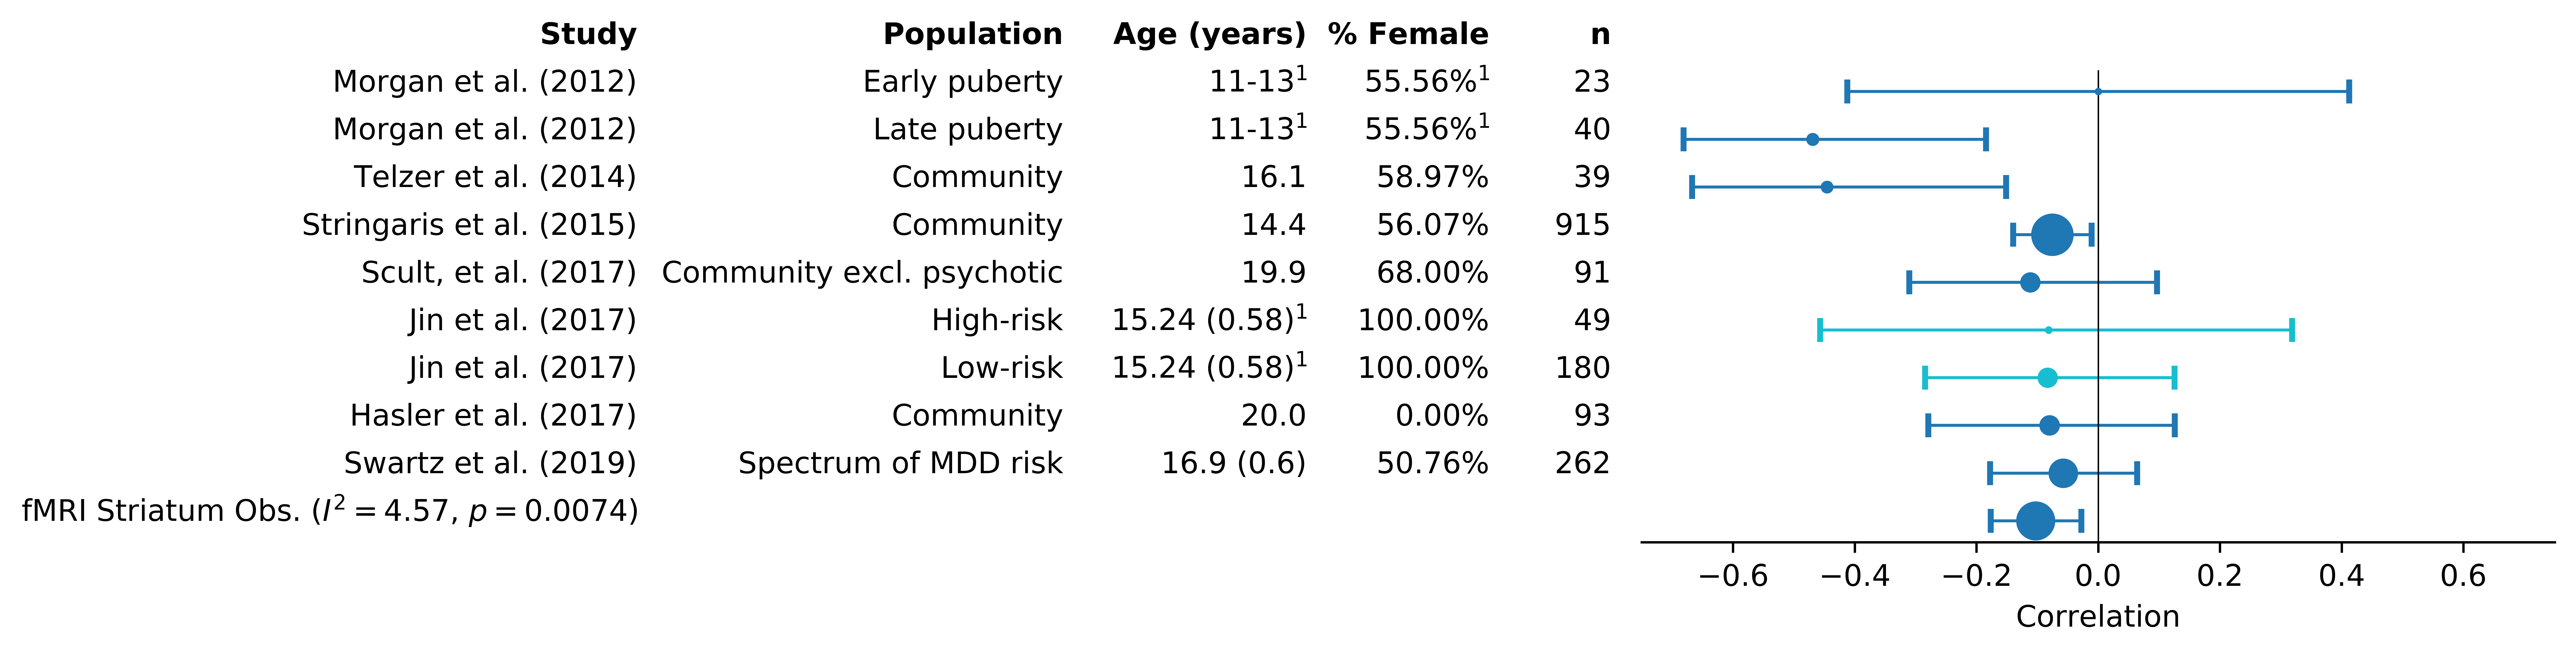

In [12]:
to_plot = plot_preds('fmri_spc_obs', columns)


r       lci       uci
13  0.172049  0.094282  0.247728

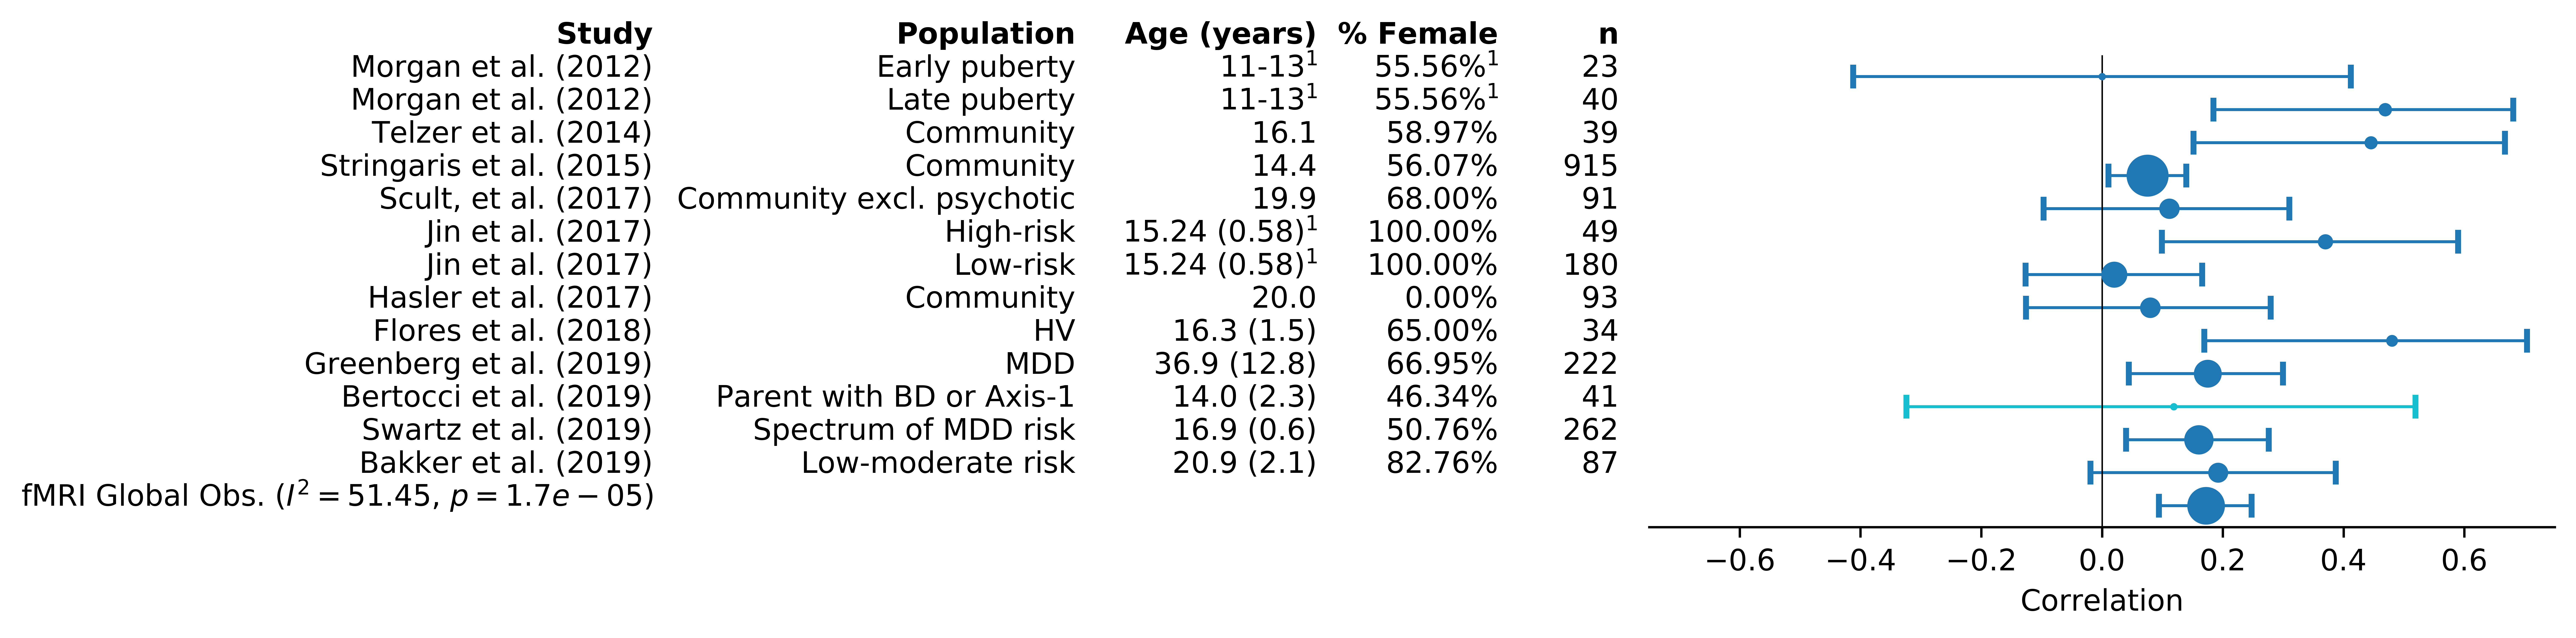

In [13]:
plot_preds('fmri_glb_obs', columns)


r       lci       uci
6  0.362361  0.184705  0.517085

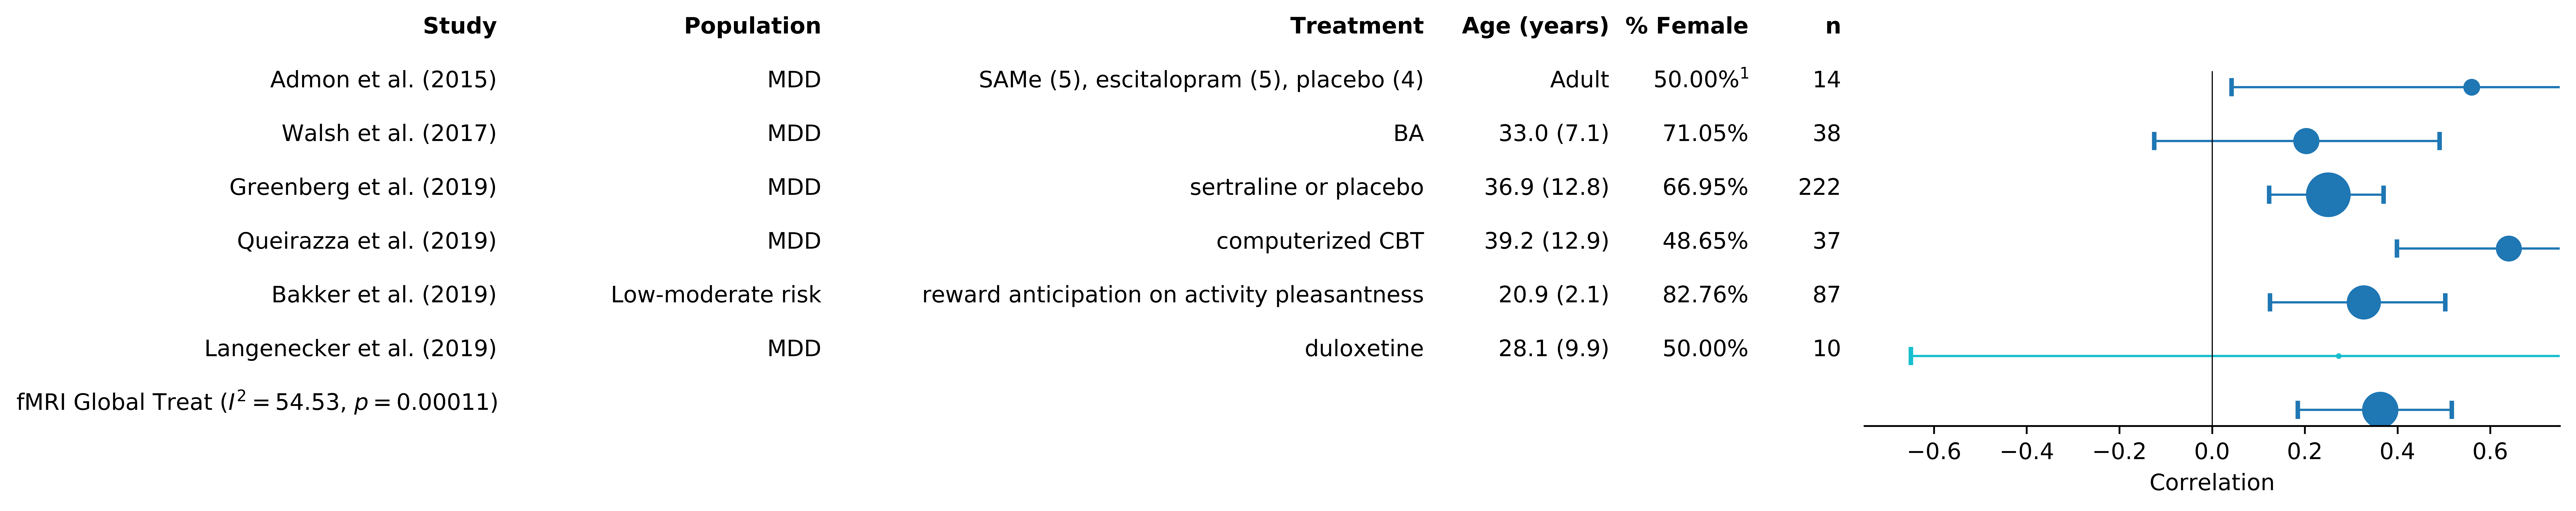

In [14]:
treat_columns = {'Study':-3.7, 'Population':-3.0, 'Treatment': -1.7, 'Age (years)':-1.3, '% Female':-1, 'n':-0.8}

plot_preds('fmri_glb_trt', treat_columns)

r       lci       uci
6  0.362361  0.184705  0.517085

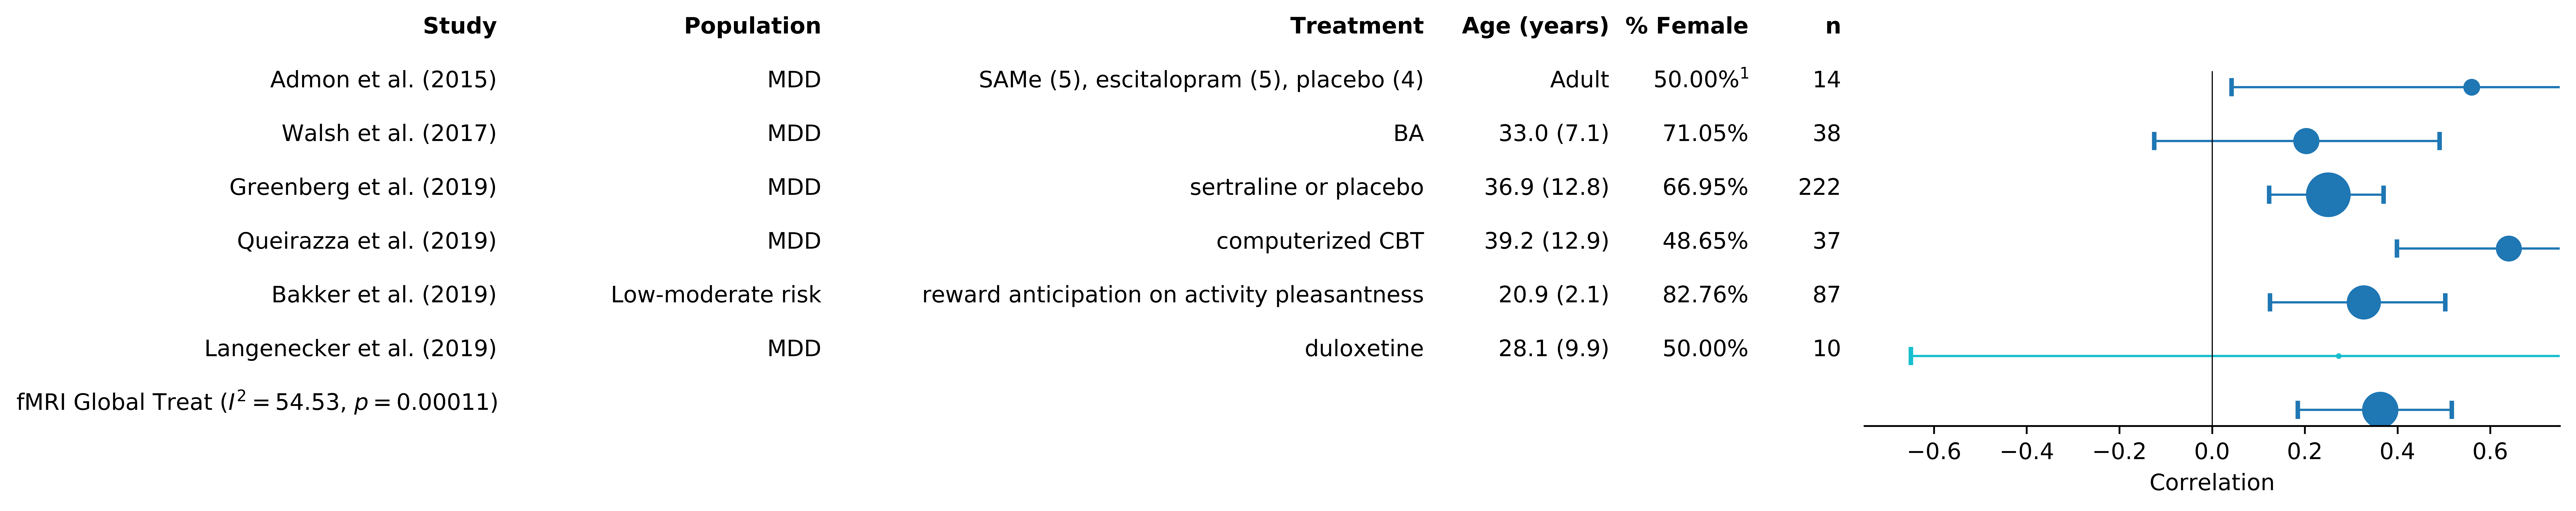

In [15]:
treat_columns = {'Study':-3.7, 'Population':-3.0, 'Treatment': -1.7, 'Age (years)':-1.3, '% Female':-1, 'n':-0.8}

plot_preds('fmri_glb_trt', treat_columns)

r       lci       uci
5 -0.175345 -0.303658 -0.040786

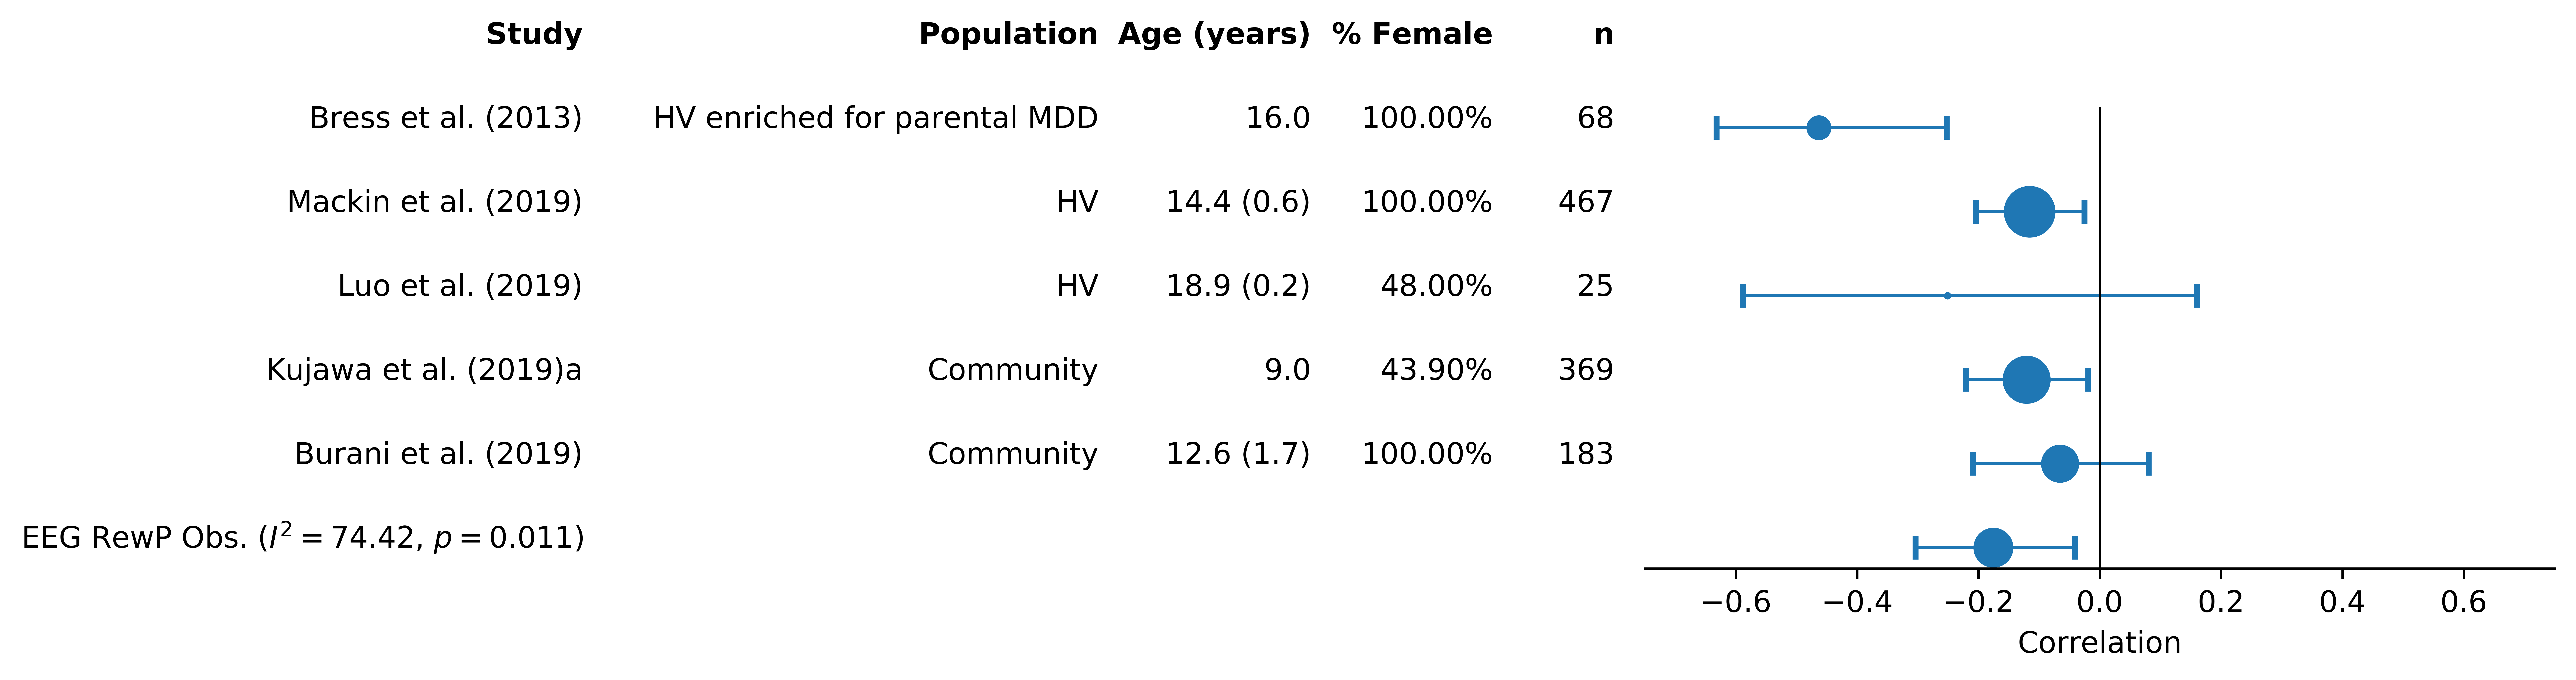

In [16]:
wide_columns = {'Study':-2.5, 'Population':-1.65, 'Age (years)':-1.3, '% Female':-1, 'n':-0.8}

plot_preds('eeg_spc_obs', wide_columns)


r       lci       uci
6 -0.161238 -0.267487 -0.051114

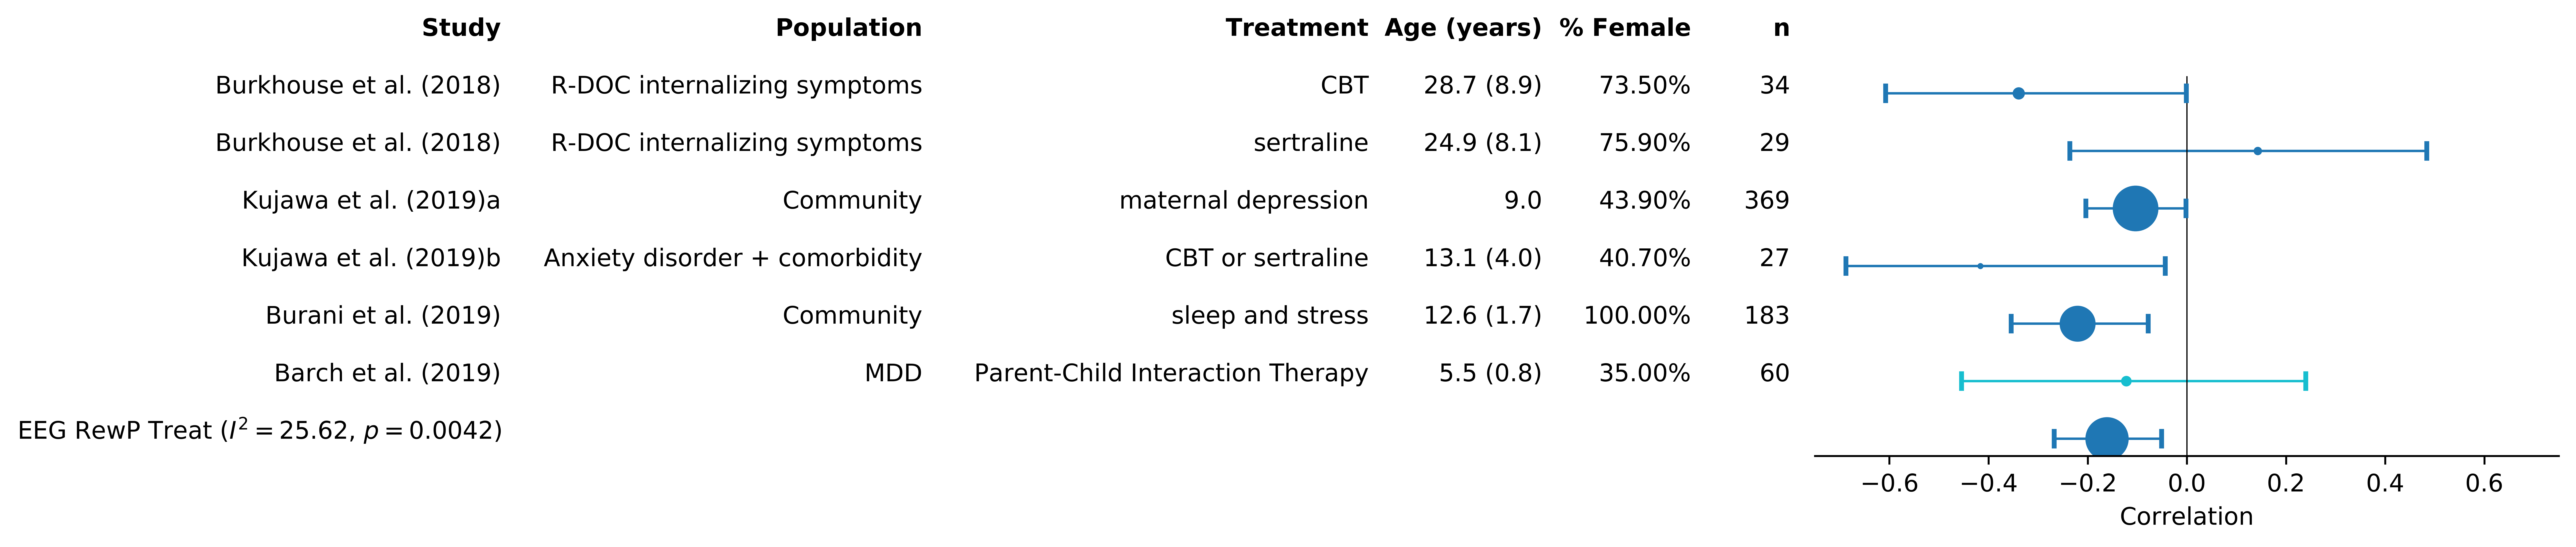

In [17]:
treat_columns = {'Study':-3.4,'Population':-2.55, 'Treatment':-1.65, 'Age (years)':-1.3, '% Female':-1, 'n':-0.8}

plot_preds('eeg_spc_trt', treat_columns)


r      lci       uci
5  0.202831  0.04628  0.349657

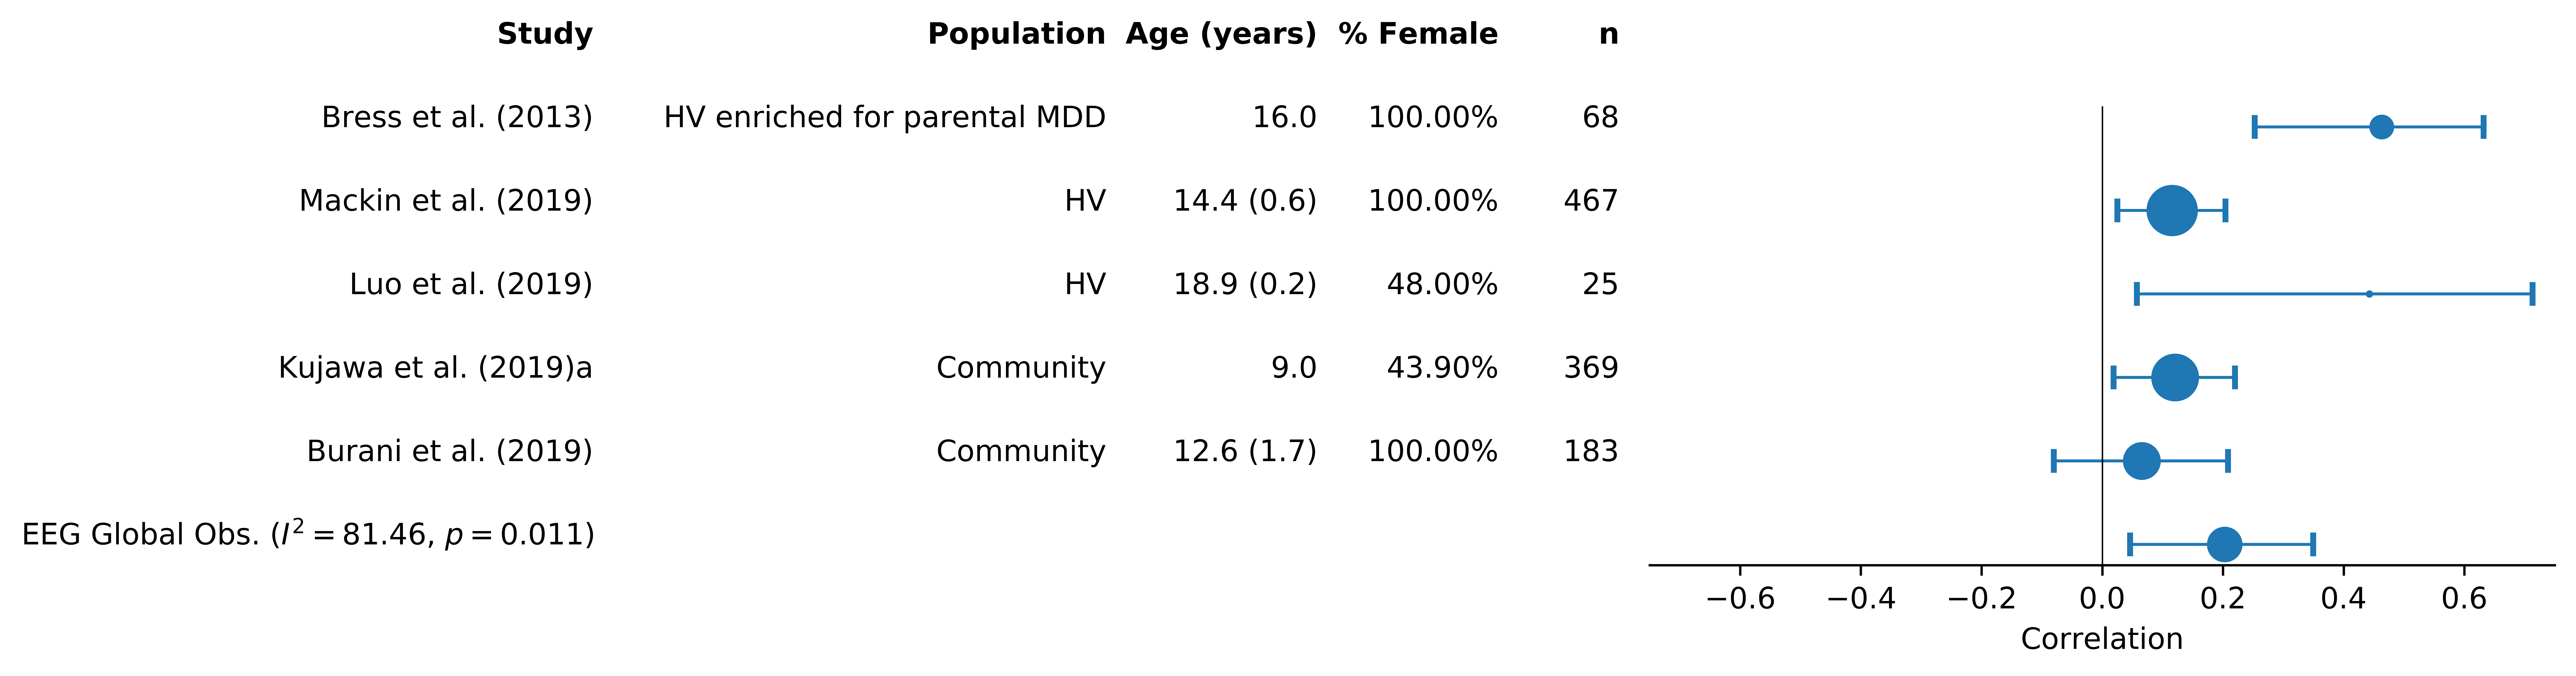

In [18]:
plot_preds('eeg_glb_obs', wide_columns)


r       lci       uci
6  0.196146  0.097896  0.290609

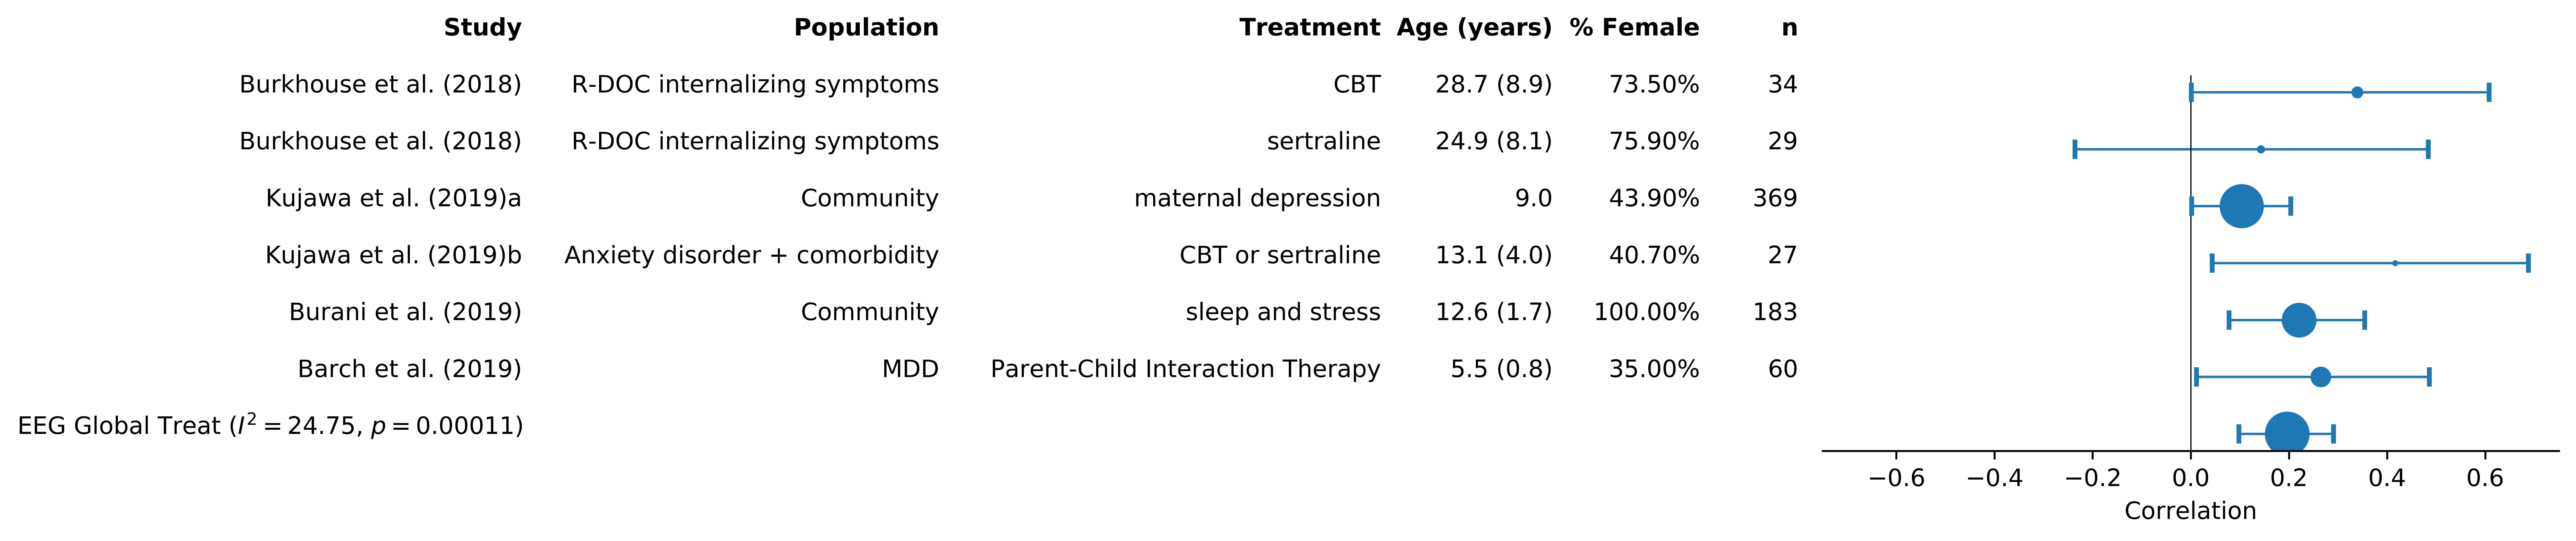

In [19]:
plot_preds('eeg_glb_trt', treat_columns)


# Miscellaneous calculations

In [34]:
1 - stats.f.cdf(6.61, 1, 11)

0.026004388615504248

In [3]:
stats.t.ppf(0.023/2, 908)

-2.2773021058841487

In [39]:
np.arctanh(0.2) / np.sqrt(1 / (11-3))

0.5734142549556392

In [40]:
np.arctanh(0.99)

2.6466524123622457

In [41]:
r_to_d(np.sqrt(0.392))

1.6059101370939324

In [42]:
-1 * stats.t.ppf(0.35/2, 91)

0.9394239852965411

In [43]:
0.086 / -1 * stats.t.ppf(0.35/2, 91)

0.08079046273550253

In [44]:
r_to_d(np.array([0.09, 0.17, 0.24]))

array([0.18073346, 0.34502212, 0.49445139])

In [45]:
0.55, 0.60, 0.64

(0.55, 0.6, 0.64)

In [46]:
r_to_d(np.array([0.04, 0.2, 0.34]))

array([0.08006408, 0.40824829, 0.723077  ])

In [47]:
0.50, 0.61, 0.70 

(0.5, 0.61, 0.7)

In [48]:
r_to_d(np.array([0.4]))

array([0.87287156])

In [49]:
r_to_d(0.51)

1.1858060399236894

In [50]:
stats.t.ppf(stats.norm.sf(3.1)/2, 9)

-4.804522108851357

In [51]:
r_to_d(np.array([-0.32237300110206796, -0.014959030776152616, -0.5741059024707514]))

array([-0.68110853, -0.02992141, -1.40234291])

# Save out sheet for supplemental

In [39]:
bs_cols = ['Study', 'Hypothesis', 'Population', 'Age', 'Female', 'N',
           'Mean Interval', 'Treatment', 'Reward Type', 'Task',  'Contrast', 'ROI', 'Statistic', 'Value', 'r', ]

In [40]:
clean_sheet = big_sheet.rename(columns={'label': 'Study', 
                                        'meta_n': 'N',
                                      'prediction_interval_days__mean': 'Mean Interval',
                                       'task': 'Task',
                                       'type_of_reward': 'Reward Type',
                                        'contrast': 'Contrast',
                                        'roi': 'ROI',
                                        'statistic':'Statistic',
                                        'value':'Value'
                                       })

In [41]:
hypo_lut = {'fmri_spc_obs': 'fMRI Striatum Obs.',
            'fmri_spc_trt': 'fMRI Striatum Treat',
            'fmri_glb_trt': 'fMRI Global Treat',
            'fmri_glb_obs': 'fMRI Global Obs.',
            'eeg_spc_trt': 'EEG RewP Treat',
            'eeg_spc_obs': 'EEG RewP Obs.',
            'eeg_glb_trt': 'EEG Global Treat',
            'eeg_glb_obs': 'EEG Global Obs.'
           }
clean_sheet['Hypothesis'] = ''
for hc in hyp_cols:
    clean_sheet.loc[clean_sheet[hc] == 1, 'Hypothesis'] += f', {hypo_lut[hc]}'
    clean_sheet['Hypothesis'] = clean_sheet.Hypothesis.str.strip(',').str.strip(' ')

In [42]:
clean_sheet = clean_sheet.loc[clean_sheet.include_any == 1, bs_cols]
clean_sheet['N'] = clean_sheet.N.astype(int)

In [43]:
clean_sheet.loc[clean_sheet.Study == 'Jin et al. (2017)a', 'Study'] = 'Jin et al. (2017) High-risk'
clean_sheet.loc[clean_sheet.Study == 'Jin et al. (2017)b', 'Study'] = 'Jin et al. (2017) Low-risk'
clean_sheet.loc[clean_sheet.Study == 'Burkhouse et al. (2018)a', 'Study'] = 'Burkhouse et al. (2018) CBT'
clean_sheet.loc[clean_sheet.Study == 'Burkhouse et al. (2018)b', 'Study'] = 'Burkhouse et al. (2018) Setraline'
clean_sheet.loc[clean_sheet.Study == 'Morgan et al. (2012)a', 'Study'] = 'Morgan et al. (2012) Early Puberty'
clean_sheet.loc[clean_sheet.Study == 'Morgan et al. (2012)b', 'Study'] = 'Morgan et al. (2012) Late Puberty'

In [44]:
clean_sheet['r'] = clean_sheet.r.apply(lambda r: f'{r:0.2f}')
clean_sheet['Value'] = clean_sheet.Value.apply(lambda r: f'{r:0.2f}')

In [45]:
clean_sheet.loc[clean_sheet['Mean Interval'] == 'slope of biweekly assessments over course of 15 weeks assessed with mixed effects model', 'Mean Interval'] = f'{15 * 7 / 2:0.2f}$^2$'

In [46]:
clean_sheet.sort_values('Study').to_csv(output_path/'meta_info.csv', index=None)